In [1]:
# ! pip install langdetect --quiet

Importing necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## detect language of the text
from langdetect import detect

## Data Preparation

* Load metadata
* Get the path of all json files.
* Extract the body text of all the papers from the json files.
* Combine the metadata and the body text.
* Determine the language of each paper and keep only those in English.
* Remove null and duplicate values 

In [3]:
path = '/kaggle/input/CORD-19-research-challenge/'
output_path = 'Data/'

# loading metadata
df = pd.read_csv(output_path+'metadata.csv')
df = df.rename(columns={'sha':'paper_id'})
df.head()

/Users/fidahussainrao/tensorflow-test/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cord_uid,paper_id,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Getting path of all the json files

In [4]:
'''
path_to_json = path + 'document_parses/pdf_json/'
filenames = os.listdir(path_to_json)
'''

"\npath_to_json = path + 'document_parses/pdf_json/'\nfilenames = os.listdir(path_to_json)\n"

In [5]:
def format_text(text):
    
    text_list = [(body['section'], body['text']) for body in text]
    dict_text = {d['section']:'' for d in text}
    
    for sec, body in text_list:
        dict_text[sec] += body
    
    return dict_text



def load_text(text):
    
    full_body = ''
    dict_text = format_text(text)
    for section, text in dict_text.items():
        full_body += section
        full_body += '\n\n'
        full_body += text
        full_body += '\n\n'
    return full_body



def load_df(files):
    
    paper_id = []
    body = []
    
    for paper in range(len(files)):
        current_paper = files[paper]
        
        paper_id.append(current_paper['paper_id'])
        body.append(load_text(current_paper['body_text']))
        
    df = pd.DataFrame(zip(paper_id, body), 
                      columns=['paper_id', 'body_text'])
        
    return df

Due to computational constraints, we will choose 25000 rows at random from the dataset and proceed with them.

In [7]:
'''
random.seed(42)
filenames = random.choices(filenames, k=25000)

json_files = []
for filename in filenames:
    filename = path_to_json + filename
    file = json.load(open(filename, 'rb'))
    json_files.append(file)
    

df_text = load_df(json_files)
'''
df_text = pd.read_csv(output_path+'df_text.csv')
df_text.head()

,paper_id,body_text
0,357a9cab01a3d9ba91c444ce43c5994e540e5d11,"\n\nA novel coronavirus, SARS-CoV-2, has been ..."
1,ce44ae196ace1fa4759367a8dd12bcfe7898bb79,Persistent hyposalivation in patients after CO...
2,76fb8e14901190e16cb442d7f46f426719db888e,Introduction\n\nThe novel coronavirus was firs...
3,0d53bcc821e58c36c25a5cced8511905c7bc495e,Summary Background\n\nThe key role of inflamma...
4,24c1b01ff3b7b7af670908187e18414fec555d0e,"INTRODUCTION\n\nIn December 2019, severe acute..."


In [13]:
final_df = pd.merge(df_text, df, on='paper_id')
## removing irrelevant columns from the merged dataset.
feats=['paper_id','doi', 'title','authors', 
       'journal', 'abstract', 'body_text']

final_df = final_df[feats]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21847 entries, 0 to 21846
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   21847 non-null  object
 1   doi        21063 non-null  object
 2   title      21847 non-null  object
 3   authors    21636 non-null  object
 4   journal    19774 non-null  object
 5   abstract   18666 non-null  object
 6   body_text  21847 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


In [14]:
# drop null values, and duplicate values if there are any..

final_df = final_df.dropna()
final_df = final_df.drop_duplicates()
final_df = final_df.reset_index(drop=True)
final_df.shape

(15916, 7)

Determine the language of each paper based on the body text provided. Only keep the papers written in English.



100%|█████████████████████████████████████| 15916/15916 [07:02<00:00, 37.65it/s]


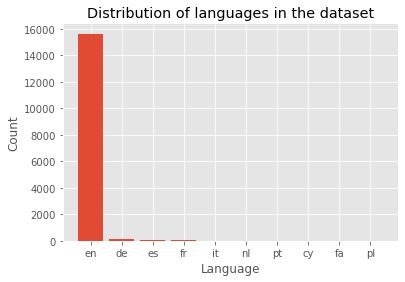

In [16]:
lang = []

for col in tqdm(range(len(final_df))):
    try:
        lang.append(detect(final_df['body_text'].iloc[col]))
    except:
        lang.append('No text provided')
        

final_df['language'] = lang

lang_counts = final_df['language'].value_counts()
plt.title('Distribution of languages in the dataset')
plt.bar(lang_counts.index, lang_counts)
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [17]:
final_df = final_df[final_df['language'] == 'en']
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15640 entries, 0 to 15915
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   15640 non-null  object
 1   doi        15640 non-null  object
 2   title      15640 non-null  object
 3   authors    15640 non-null  object
 4   journal    15640 non-null  object
 5   abstract   15640 non-null  object
 6   body_text  15640 non-null  object
 7   language   15640 non-null  object
dtypes: object(8)
memory usage: 1.1+ MB


In [18]:
final_df.to_csv(output_path+'data.csv', index=False)